In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks, hilbert
from scipy.integrate import odeint

# === Load EEG data (replace with your path) ===
file_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/EEG.csv"
EEG = pd.read_csv(file_path)

real_data_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/Epileptogenic_Results.csv"
df = pd.read_csv(real_data_path)


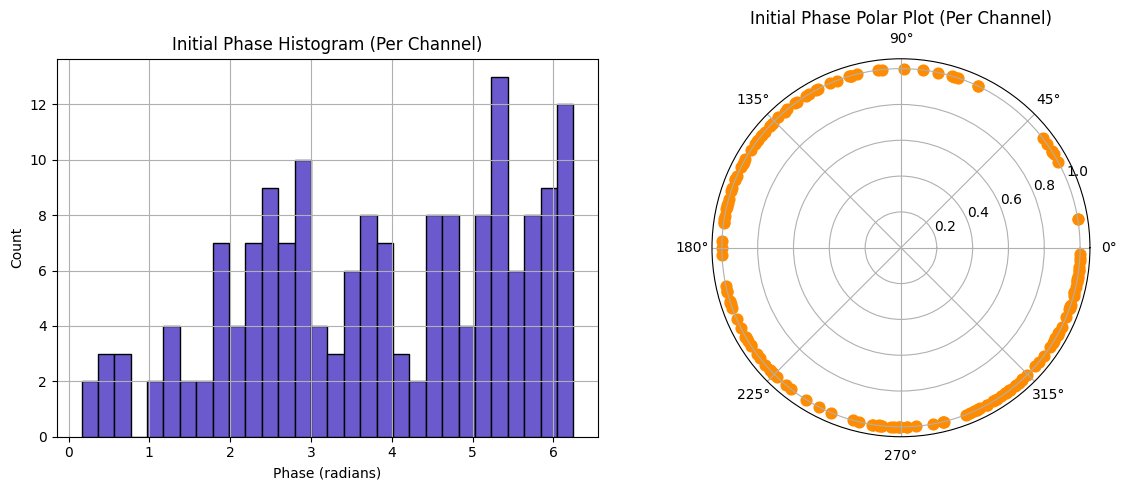

In [2]:
import numpy as np
import pandas as pd
from scipy.signal import resample, hilbert
from PyEMD import EMD
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# === Parameters ===
fs_original = 500
downsample_factor = 1
EEG_segment = EEG.iloc[:27000]  # your EEG DataFrame
channels = EEG_segment.columns

# === Function to extract initial phase of IMF₁ ===
def extract_initial_phase(signal, downsample_factor=5):
    signal_ds = resample(signal, len(signal) // downsample_factor)
    emd = EMD()
    imfs = emd(signal_ds)

    if len(imfs) == 0:
        return np.nan  # Skip if no IMFs

    imf1 = imfs[0]  # Use only the first IMF
    analytic_signal = hilbert(imf1)
    initial_phase = np.angle(analytic_signal[0])
    return np.mod(initial_phase, 2 * np.pi)  # Wrap to [0, 2π)

# === Parallel Processing ===
initial_phases = Parallel(n_jobs=-1)(
    delayed(extract_initial_phase)(EEG_segment[ch].values, downsample_factor)
    for ch in channels
)

# === Store as Series ===
initial_phase_series = pd.Series(initial_phases, index=channels, name="Initial Phase (rad)")

# === Plot Histogram ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(initial_phase_series, bins=30, color='slateblue', edgecolor='black')
plt.title("Initial Phase Histogram (Per Channel)")
plt.xlabel("Phase (radians)")
plt.ylabel("Count")
plt.grid(True)

# === Plot Polar Scatter ===
plt.subplot(1, 2, 2, projection='polar')
plt.scatter(initial_phase_series, np.ones_like(initial_phase_series), color='darkorange', s=60)
plt.title("Initial Phase Polar Plot (Per Channel)")

plt.tight_layout()
plt.show()


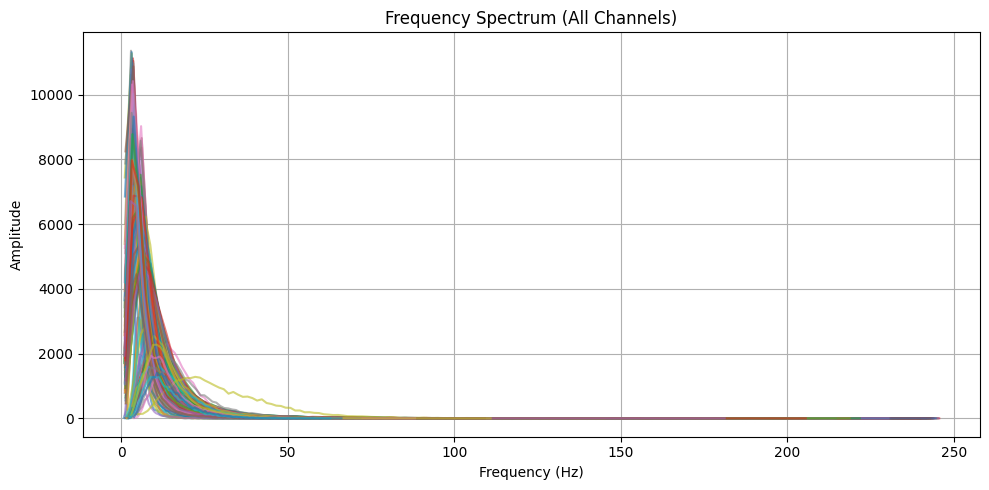

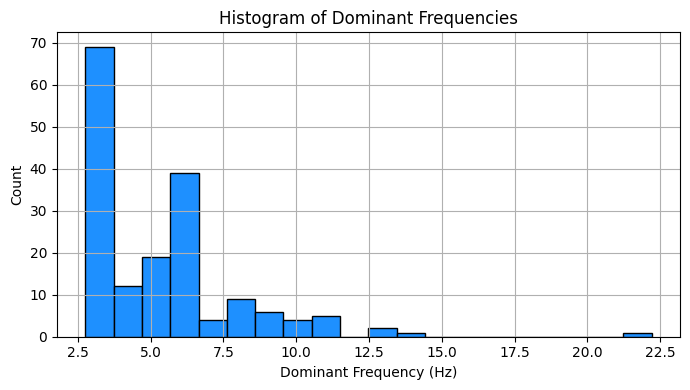

In [3]:
import numpy as np
import pandas as pd
from scipy.signal import resample, hilbert
from PyEMD import EMD
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

fs = 500
max_imfs = 5
downsample_factor = 1
EEG_segment = EEG.iloc[:27000]  # or a slice of your EEG data

# === Function: Extract weighted frequency and initial phase ===
def hht_analysis(signal, fs, downsample_factor=10, max_imfs=3):
    signal_ds = resample(signal, len(signal) // downsample_factor)
    emd = EMD()
    imfs = emd(signal_ds)[:max_imfs]
    
    analytic = hilbert(imfs)
    amplitude = np.abs(analytic)
    phase = np.angle(analytic)
    
    # Instantaneous frequency (via diff of phase)
    inst_phase = np.unwrap(phase)
    freq = np.abs(np.diff(inst_phase, axis=1) * fs / (2 * np.pi))
    amp_mid = amplitude[:, :-1]
    
    # Weighted frequency
    weighted_freq = np.sum(freq * amp_mid, axis=0) / (np.sum(amp_mid, axis=0) + 1e-8)
    
    # Dominant frequency via histogram peak
    counts, bins = np.histogram(weighted_freq, bins=100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    dominant_freq = bin_centers[np.argmax(counts)]
    
    # Initial phase from analytic signal at t=0
    initial_phase = phase[:, 0]
    
    return weighted_freq, dominant_freq, initial_phase

# === Run in parallel for all EEG channels ===
channels = EEG_segment.columns
results = Parallel(n_jobs=-1)(
    delayed(hht_analysis)(EEG_segment[ch].values, fs, downsample_factor, max_imfs)
    for ch in channels
)

# === Organize Outputs ===
all_freqs = {ch: r[0] for ch, r in zip(channels, results)}
dominant_freqs = [r[1] for r in results]
initial_phases = {ch: r[2] for ch, r in zip(channels, results)}

# === Plot: Frequency spectra of all channels ===
plt.figure(figsize=(10, 5))
for ch in channels:
    f = all_freqs[ch]
    counts, bins = np.histogram(f, bins=100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, counts, label=ch, alpha=0.6)
plt.title("Frequency Spectrum (All Channels)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
#plt.legend(loc='upper right', fontsize=7)
plt.tight_layout()
plt.show()

# === Plot: Histogram of dominant frequencies ===
plt.figure(figsize=(7, 4))
plt.hist(dominant_freqs, bins=20, color='dodgerblue', edgecolor='black')
plt.title("Histogram of Dominant Frequencies")
plt.xlabel("Dominant Frequency (Hz)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Estimated g(omega): 0.1994
Estimated critical coupling ε_c: 3.1928


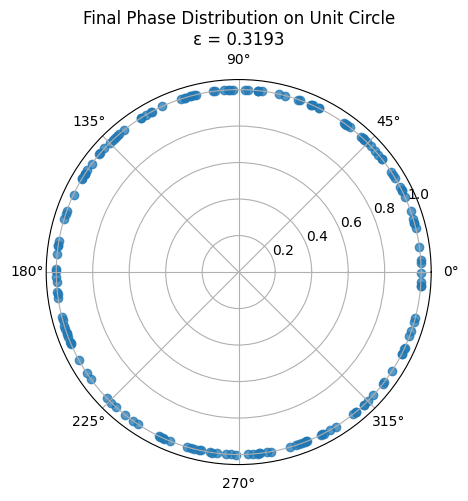

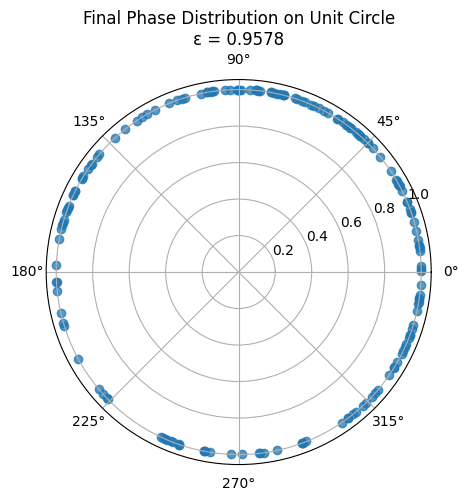

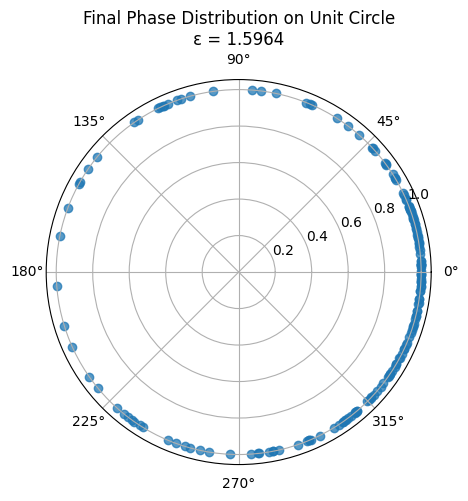

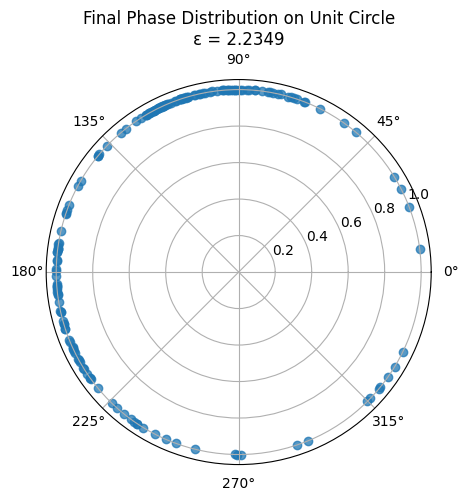

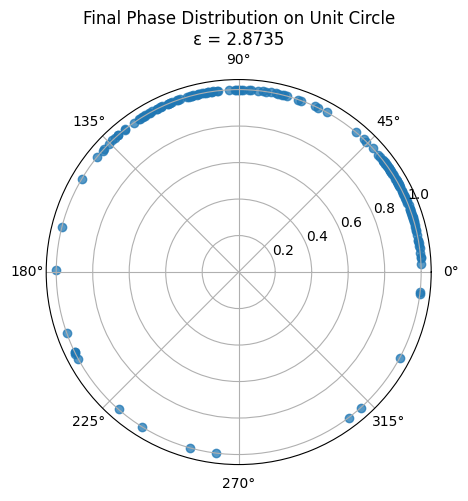

In [4]:
import numpy as np
import pandas as pd
from scipy.signal import resample, hilbert
from PyEMD import EMD
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import warnings
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore")

fs = 500
max_imfs = 5
downsample_factor = 1
EEG_segment = EEG.iloc[:27000]  # or a slice of your EEG data
T_sim = 1500  # Number of time steps
dt = 0.01  # Time step size
N = len(EEG_segment.columns)  # Number of EEG channels

# === Function: Extract weighted frequency and initial phase ===
def hht_analysis(signal, fs, downsample_factor=10, max_imfs=3):
    signal_ds = resample(signal, len(signal) // downsample_factor)
    emd = EMD()
    imfs = emd(signal_ds)[:max_imfs]
    
    analytic = hilbert(imfs)
    amplitude = np.abs(analytic)
    phase = np.angle(analytic)
    
    # Instantaneous frequency (via diff of phase)
    inst_phase = np.unwrap(phase)
    freq = np.abs(np.diff(inst_phase, axis=1) * fs / (2 * np.pi))
    amp_mid = amplitude[:, :-1]
    
    # Weighted frequency
    weighted_freq = np.sum(freq * amp_mid, axis=0) / (np.sum(amp_mid, axis=0) + 1e-8)
    
    # Dominant frequency via histogram peak
    counts, bins = np.histogram(weighted_freq, bins=100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    dominant_freq = bin_centers[np.argmax(counts)]
    
    # Initial phase from analytic signal at t=0
    initial_phase = phase[:, 0]
    
    return weighted_freq, dominant_freq, initial_phase

# === Run in parallel for all EEG channels ===
channels = EEG_segment.columns
results = Parallel(n_jobs=-1)(
    delayed(hht_analysis)(EEG_segment[ch].values, fs, downsample_factor, max_imfs)
    for ch in channels
)

# === Organize Outputs ===
all_freqs = {ch: r[0] for ch, r in zip(channels, results)}
dominant_freqs = [r[1] for r in results]
initial_phases = {ch: r[2] for ch, r in zip(channels, results)}

# Use EMD-derived frequencies
natural_freqs_emd = np.array(dominant_freqs)
omega = natural_freqs_emd # Natural frequencies (fixed during TLE calculation)

# === Step 2: Estimate g(omega) and critical epsilon ===
kde = gaussian_kde(omega)
density_values = kde.evaluate(omega)
g_omega = np.max(density_values)
epsilon_critical = 2 / (np.pi * g_omega)

print(f"Estimated g(omega): {g_omega:.4f}")
print(f"Estimated critical coupling ε_c: {epsilon_critical:.4f}")

epsilons = np.linspace(0.1 * epsilon_critical, 0.9 * epsilon_critical, 5)

# === Function to extract initial phase of IMF₁ ===
def extract_initial_phase(signal, downsample_factor=5):
    signal_ds = resample(signal, len(signal) // downsample_factor)
    emd = EMD()
    imfs = emd(signal_ds)

    if len(imfs) == 0:
        return np.nan  # Skip if no IMFs

    imf1 = imfs[0]  # Use only the first IMF
    analytic_signal = hilbert(imf1)
    initial_phase = np.angle(analytic_signal[0])
    return np.mod(initial_phase, 2 * np.pi)  # Wrap to [0, 2π)
# === Parallel Processing for initial phases ===
initial_phases = Parallel(n_jobs=-1)(
    delayed(extract_initial_phase)(EEG_segment[ch].values, downsample_factor) for ch in EEG_segment.columns
)

initial_phases = np.array(initial_phases)

for epsilon in epsilons:
    x = np.array(initial_phases)
    phase_history = np.zeros((T_sim, N))
    phase_history[0] = x

    # === Simulate phase dynamics (Kuramoto model) ===
    for t in range(1, T_sim):
        x_new = np.copy(x)
        for k in range(N):
            coupling_sum = np.sum(np.sin(x - x[k])) - np.sin(0)  # Exclude self-term
            x_new[k] += dt * (omega[k] + (epsilon / N) * coupling_sum)
        x = x_new
        phase_history[t] = x

    # === Plot 3: Polar plot of final wrapped phases ===
    final_phases = np.mod(phase_history[-1], 2 * np.pi)
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(111, polar=True)
    ax.scatter(final_phases, np.ones_like(final_phases), alpha=0.75)
    ax.set_title(f'Final Phase Distribution on Unit Circle\nε = {epsilon:.4f}')
    plt.show()



In [5]:
import numpy as np
import pandas as pd
from scipy.signal import resample, hilbert
from PyEMD import EMD
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# === Parameters and data ===
fs = 500
max_imfs = 5
downsample_factor = 1
EEG_segment = EEG.iloc[:27000]  # Use first 27000 samples or your segment
channels = EEG_segment.columns

# --- Step 1: Extract initial phases from first IMF using EMD + Hilbert ---
def extract_initial_phase(signal, downsample_factor=5):
    signal_ds = resample(signal, len(signal) // downsample_factor)
    emd = EMD()
    imfs = emd(signal_ds)

    if len(imfs) == 0:
        return np.nan  # Skip if no IMFs

    imf1 = imfs[0]  # First IMF only
    analytic_signal = hilbert(imf1)
    initial_phase = np.angle(analytic_signal[0])
    return np.mod(initial_phase, 2 * np.pi)  # Wrap to [0, 2π)

# Parallel extraction of initial phases per channel
initial_phases_emd = Parallel(n_jobs=-1)(
    delayed(extract_initial_phase)(EEG_segment[ch].values, downsample_factor)
    for ch in channels
)
initial_phases = pd.Series(initial_phases_emd, index=channels, name="Initial Phase (rad)")

initial_phases = np.array(initial_phases)

x = np.array(initial_phases)  # Initial phases (fixed during TLE calculation)

# === Step 2: Compute TLEs for each channel ===
TLEs = np.zeros(N)
for k in range(N):
    cos_sum = 0
    for j in range(N):
        if j != k:
            cos_sum += np.cos(x[j] - x[k])
    TLEs[k] = - (epsilon / N) * cos_sum

# === Step 3: Threshold TLEs to determine simulated epileptogenicity ===
# Stable (TLE ≤ 0): 1 = Epileptogenic
# Unstable (TLE > 0): 0 = Non-epileptogenic
Epileptogenic_simulated = (TLEs <= 0).astype(int)
Epileptogenic_sim = np.column_stack((channels, Epileptogenic_simulated.astype(str)))

# Ensure columns match EEG channels
Epileptogenic_real = np.column_stack((channels, df['Epileptogenic'].to_numpy().astype(str)))

# === Step 5: Cross-tabulation of simulation vs real labels ===
sim_vals = Epileptogenic_sim[:, 1].astype(int)
real_vals = Epileptogenic_real[:, 1].astype(int)

cross_table = np.zeros((2, 2), dtype=int)
for s, r in zip(sim_vals, real_vals):
    cross_table[s, r] += 1

# Format using pandas for readability
df_cross = pd.DataFrame(cross_table,
                        index=['Sim=0 (Non-Epi)', 'Sim=1 (Epi)'],
                        columns=['Real=0 (Non-Epi)', 'Real=1 (Epi)'])

print("\nCross-tabulation (Simulated vs Real Epileptogenicity):")
print(df_cross)



Cross-tabulation (Simulated vs Real Epileptogenicity):
                 Real=0 (Non-Epi)  Real=1 (Epi)
Sim=0 (Non-Epi)                50            22
Sim=1 (Epi)                    69            30
